In [6]:
INPUT_PATH = "/raid/prateek/original_datasets/condition/ich/ich_segmentation/data/image"
LABEL_PATH = "/raid/prateek/original_datasets/condition/ich/ich_segmentation/data/label"
%matplotlib inline

In [7]:
# !conda install scikit-learn -y

In [24]:
import torch
import matplotlib.pyplot as plt
from pydicom import dcmread 
import PIL
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import wandb
print("Packages Loaded")

Packages Loaded


In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #GPU #2

In [10]:
import pathlib
input_list = list(pathlib.Path(INPUT_PATH).rglob("*.png"))
# print(len(input_list))
input_filenames = [os.path.basename(i) for i in input_list]
input_filenames[0:5], len(input_filenames)

(['1903.png', '1702.png', '719.png', '2084.png', '665.png'], 2814)

In [11]:
from sklearn.model_selection import train_test_split
inputs = {}
inputs["train"], inputs["val"] = train_test_split(input_filenames, test_size=0.2)
len(inputs["train"]),len(inputs["val"])

(2251, 563)

In [12]:
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomPerspective(),
#     transforms.RandomResizedCrop(size=(224,224)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [13]:
val_tf = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(45),
    # transforms.RandomPerspective(),
#     transforms.RandomResizedCrop(size=(224,224)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class SliceDatasetBinary(Dataset):
    def __init__(self, image_list:list, image_path:str, label_path:str, image_size=(224, 224), transform=None):
        self.image_list = image_list
        self.image_path = image_path
        self.label_path = label_path
        self.transform = transform
        self.image_size = image_size
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx:int)->torch.Tensor:
        filename = self.image_list[idx]
        image_path = f"{self.image_path}/{filename}"
        label_path = f"{self.label_path}/{filename}"
        image = Image.open(image_path).resize(self.image_size, PIL.Image.LANCZOS)
        label = Image.open(label_path).resize(self.image_size, PIL.Image.LANCZOS)
        sample = {"image": transforms.ToTensor()(image), "label": transforms.ToTensor()(label)}
        if self.transform != None:
            sample = self.transform(sample)
            print(type(sample))
        return(sample)

In [15]:
dataset = {}
dataset["train"] = SliceDatasetBinary(image_list=inputs["train"], image_path=INPUT_PATH, label_path=LABEL_PATH, transform=None)
dataset["val"] = SliceDatasetBinary(image_list=inputs["val"], image_path=INPUT_PATH, label_path=LABEL_PATH, transform=None)

In [16]:
image = dataset["train"][9]

In [17]:
image["label"].max() > 0

tensor(True)

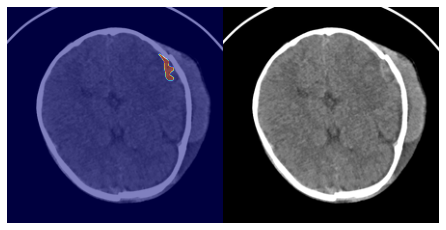

In [19]:
plt.ioff()
plt.figure() 
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.suptitle('test title', fontsize=20)
plt.subplot(1,2,1)
plt.imshow(image["image"].permute(2,1,0), cmap="gray")
plt.imshow(image["label"].permute(2,1,0), cmap="jet", alpha=0.5)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image["image"].permute(2,1,0), cmap="gray")
plt.axis('off')
plt.savefig("test.png", dpi=400, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

In [20]:
from torch.utils.data import Dataset, DataLoader
dataloaders = {}
dataloaders['train'] = DataLoader(dataset['train'], batch_size=16, num_workers=8)
dataloaders['val'] = DataLoader(dataset['val'], batch_size=16, num_workers=8)

In [21]:
# Testing dataset import
from tqdm import tqdm
print("Train dataset")
for i in tqdm(dataloaders['train']):
    pass
print("Val dataset")
for i in tqdm(dataloaders['val']):
    pass

  0%|          | 0/141 [00:00<?, ?it/s]

Train dataset


  0%|          | 0/36 [00:00<?, ?it/s]

Val dataset


100%|██████████| 36/36 [00:01<00:00, 24.48it/s]


In [26]:
#importing a u-net
from architectures.unet import UNet

wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: prtksngh (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [33]:
net = UNet(n_channels=1, n_classes=1, bilinear=True)
net.cuda()
wandb.watch(net)
lr = 0.001
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
from torch import optim
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-8)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [35]:
import torch.nn as nn
if net.n_classes > 1:
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.BCEWithLogitsLoss()

In [36]:
resume = False
checkpoint_path = "./04A_checkpoints"
resume_path = ""


In [37]:

def save_image_from_batch(images, masks, index):
    for i in images:
        
    return index+len(images)

idx = 1
for batch in dataloaders['val']:
    print(idx)
    images = batch['image']
    masks = batch['label']
    idx = save_image_from_batch(images, masks, idx)

IndentationError: expected an indented block (<ipython-input-37-9aac184d60a0>, line 4)

In [38]:
from tqdm import tqdm
from pathlib import Path

def save_checkpoint(model, optimizer, loss, epoch, filename, path="."):
    Path(path).mkdir(parents=True, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss}, f'{path}/{filename}')
    print(f'Save complete for {path+"/"+filename}')

def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return (model, optimizer, epoch, loss)

current_epoch=0
if resume:
    net, optimizer, current_epoch, _ = load_checkpoint(resume_path)

for epoch in tqdm(range(current_epoch,100)):
    running_loss = 0.0
    wandb.log({'Epoch':epoch+1})
    loss_array = []
    net.train()
    correct = 0; total = 0
    for i, batch in enumerate(tqdm(dataloaders["train"])):
        # zero the parameter gradients
        x = batch['image'].cuda()
        y = batch['label'].cuda()
        optimizer.zero_grad()
        #forward pass
        y_hat = net(x)
        loss = criterion(y_hat, y)
        #backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_array.append(loss.item())
#         _, predicted = torch.max(y_hat.data, 1)
#         _, label = torch.max(y.data, 1)
#         total += len(label)
#         correct += (predicted == label).sum().item()
        if i % 20 == 19:    # print every 20 mini-batches
#             print(f'[{epoch+1}/{i+1}] {running_loss/2000}')
            wandb.log({"Train Loss": running_loss/20})
            running_loss = 0.0
    save_checkpoint(net, optimizer, sum(loss_array)/len(loss_array), epoch, path=checkpoint_path, 
        filename=f"resume_epoch{epoch}_loss{sum(loss_array)/len(loss_array)}.pth")
    val_losses = []
    correct = 0; total = 0    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloaders["val"])):
            x = batch['image'].cuda()
            y = batch['label'].cuda()
            outputs = net(x)
#             print("Done")
#             _, predicted = torch.max(outputs.data, 1)
#             print(predicted)
#             _, label = torch.max(labels.data, 1)
            val_loss = criterion(outputs, y)
            val_losses.append(val_loss.item())
#             print(label)
#             total += len(label)
#             correct += (predicted == label).sum().item()
    save_checkpoint(net, optimizer, sum(loss_array)/len(loss_array), epoch, path=checkpoint_path,
                filename=f"checkpoint_epoch{epoch}_loss{sum(loss_array)/len(loss_array)}.pth")
    wandb.log({"Validation Loss": sum(val_losses)/len(val_losses)})
#     print(f'Accuracy of the network:{correct / total}')

torch.save(net.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))


100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch0_loss0.16988893704000094.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch0_loss0.16988893704000094.pth



100%|██████████| 141/141 [00:26<00:00,  5.34it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch1_loss0.02794817630994193.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch1_loss0.02794817630994193.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch2_loss0.013354266746009284.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch2_loss0.013354266746009284.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch3_loss0.009277380325877709.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch3_loss0.009277380325877709.pth



100%|██████████| 141/141 [00:26<00:00,  5.37it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch4_loss0.007413060214462961.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch4_loss0.007413060214462961.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch5_loss0.006061414413563643.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch5_loss0.006061414413563643.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch6_loss0.005508133145841829.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch6_loss0.005508133145841829.pth



100%|██████████| 141/141 [00:26<00:00,  5.34it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch7_loss0.004610519363307097.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch7_loss0.004610519363307097.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch8_loss0.004337705237500317.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch8_loss0.004337705237500317.pth



100%|██████████| 141/141 [00:26<00:00,  5.34it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch9_loss0.00378087513538487.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch9_loss0.00378087513538487.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch10_loss0.003787736322133016.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch10_loss0.003787736322133016.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch11_loss0.0034805883357056965.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch11_loss0.0034805883357056965.pth



100%|██████████| 141/141 [00:26<00:00,  5.34it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch12_loss0.003146275913867941.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch12_loss0.003146275913867941.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch13_loss0.0028775062999053997.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch13_loss0.0028775062999053997.pth



100%|██████████| 141/141 [00:26<00:00,  5.33it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch14_loss0.002931544107446077.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch14_loss0.002931544107446077.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch15_loss0.002820035501536814.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch15_loss0.002820035501536814.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch16_loss0.002572536577696826.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch16_loss0.002572536577696826.pth



100%|██████████| 141/141 [00:26<00:00,  5.37it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch17_loss0.0026383496241326977.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch17_loss0.0026383496241326977.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch18_loss0.0023049233567567396.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch18_loss0.0023049233567567396.pth



100%|██████████| 141/141 [00:26<00:00,  5.33it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch19_loss0.0026277305578139235.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch19_loss0.0026277305578139235.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch20_loss0.0024677232374950703.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch20_loss0.0024677232374950703.pth



100%|██████████| 141/141 [00:26<00:00,  5.34it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch21_loss0.0021680792282147213.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch21_loss0.0021680792282147213.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch22_loss0.002022906911954885.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch22_loss0.002022906911954885.pth



100%|██████████| 141/141 [00:26<00:00,  5.37it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch23_loss0.0019322113211989957.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch23_loss0.0019322113211989957.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch24_loss0.0018905617816023634.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch24_loss0.0018905617816023634.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch25_loss0.0017805882427818307.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch25_loss0.0017805882427818307.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch26_loss0.001679956725367563.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch26_loss0.001679956725367563.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch27_loss0.0015687822660056425.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch27_loss0.0015687822660056425.pth



100%|██████████| 141/141 [00:26<00:00,  5.32it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch28_loss0.0015987057055318597.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch28_loss0.0015987057055318597.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch29_loss0.0021679756067613147.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch29_loss0.0021679756067613147.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch30_loss0.001770617280684656.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch30_loss0.001770617280684656.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch31_loss0.0015956001939971978.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch31_loss0.0015956001939971978.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch32_loss0.001446079848702016.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch32_loss0.001446079848702016.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch33_loss0.0013925850893274207.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch33_loss0.0013925850893274207.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch34_loss0.0014883675740999566.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch34_loss0.0014883675740999566.pth



100%|██████████| 141/141 [00:26<00:00,  5.29it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch35_loss0.0013793238195308306.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch35_loss0.0013793238195308306.pth



100%|██████████| 141/141 [00:26<00:00,  5.30it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch36_loss0.0013121331973597473.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch36_loss0.0013121331973597473.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch37_loss0.0013595230008980363.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch37_loss0.0013595230008980363.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch38_loss0.0012747134865449036.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch38_loss0.0012747134865449036.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch39_loss0.001210104664967227.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch39_loss0.001210104664967227.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch40_loss0.0011958435087188986.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch40_loss0.0011958435087188986.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch41_loss0.001089604422562559.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch41_loss0.001089604422562559.pth



100%|██████████| 141/141 [00:26<00:00,  5.32it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch42_loss0.0010912363044463481.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch42_loss0.0010912363044463481.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch43_loss0.001188196558772598.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch43_loss0.001188196558772598.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch44_loss0.0010178809482677541.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch44_loss0.0010178809482677541.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch45_loss0.0010207954344503972.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch45_loss0.0010207954344503972.pth



100%|██████████| 141/141 [00:26<00:00,  5.34it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch46_loss0.0011089575354104608.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch46_loss0.0011089575354104608.pth



100%|██████████| 141/141 [00:26<00:00,  5.37it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch47_loss0.0009948550516437923.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch47_loss0.0009948550516437923.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch48_loss0.0010774967172341.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch48_loss0.0010774967172341.pth



100%|██████████| 141/141 [00:26<00:00,  5.32it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch49_loss0.0012765949561703597.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch49_loss0.0012765949561703597.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch50_loss0.0010029189217146668.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch50_loss0.0010029189217146668.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch51_loss0.0010416743376184749.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch51_loss0.0010416743376184749.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch52_loss0.0008840254819741414.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch52_loss0.0008840254819741414.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch53_loss0.0009871060033509957.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch53_loss0.0009871060033509957.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch54_loss0.0008705623943292299.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch54_loss0.0008705623943292299.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch55_loss0.0009714302573906645.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch55_loss0.0009714302573906645.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch56_loss0.000886103404603136.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch56_loss0.000886103404603136.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch57_loss0.0008420899172593404.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch57_loss0.0008420899172593404.pth



100%|██████████| 141/141 [00:26<00:00,  5.33it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch58_loss0.000813278649233235.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch58_loss0.000813278649233235.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch59_loss0.0008874235046852123.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch59_loss0.0008874235046852123.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch60_loss0.0009444243259561176.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch60_loss0.0009444243259561176.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch61_loss0.0008277982335601091.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch61_loss0.0008277982335601091.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch62_loss0.0007806448733171115.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch62_loss0.0007806448733171115.pth



100%|██████████| 141/141 [00:26<00:00,  5.33it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch63_loss0.0013114238065538547.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch63_loss0.0013114238065538547.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch64_loss0.0008352270429728017.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch64_loss0.0008352270429728017.pth



100%|██████████| 141/141 [00:26<00:00,  5.37it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch65_loss0.0007433763624100611.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch65_loss0.0007433763624100611.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch66_loss0.0007829489601484037.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch66_loss0.0007829489601484037.pth



100%|██████████| 141/141 [00:26<00:00,  5.37it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch67_loss0.0007444400791060384.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch67_loss0.0007444400791060384.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch68_loss0.000767140627705356.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch68_loss0.000767140627705356.pth



100%|██████████| 141/141 [00:26<00:00,  5.37it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch69_loss0.0009675078454681512.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch69_loss0.0009675078454681512.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch70_loss0.001425681769284783.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch70_loss0.001425681769284783.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch71_loss0.0011381953789504037.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch71_loss0.0011381953789504037.pth



100%|██████████| 141/141 [00:26<00:00,  5.34it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch72_loss0.0008241804557397983.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch72_loss0.0008241804557397983.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch73_loss0.0007636281279217732.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch73_loss0.0007636281279217732.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch74_loss0.0006887732895602763.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch74_loss0.0006887732895602763.pth



100%|██████████| 141/141 [00:26<00:00,  5.34it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch75_loss0.0007044810449447496.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch75_loss0.0007044810449447496.pth



100%|██████████| 141/141 [00:26<00:00,  5.31it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch76_loss0.0006876147163596906.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch76_loss0.0006876147163596906.pth



100%|██████████| 141/141 [00:26<00:00,  5.33it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch77_loss0.0008247398859921369.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch77_loss0.0008247398859921369.pth



100%|██████████| 141/141 [00:26<00:00,  5.30it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch78_loss0.00069111548639978.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch78_loss0.00069111548639978.pth



100%|██████████| 141/141 [00:26<00:00,  5.29it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch79_loss0.0006504553379375898.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch79_loss0.0006504553379375898.pth



100%|██████████| 141/141 [00:26<00:00,  5.30it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch80_loss0.0006350506823248565.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch80_loss0.0006350506823248565.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch81_loss0.000678036394995467.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch81_loss0.000678036394995467.pth



100%|██████████| 141/141 [00:26<00:00,  5.38it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch82_loss0.0007339245217745555.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch82_loss0.0007339245217745555.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch83_loss0.0006494145427721584.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch83_loss0.0006494145427721584.pth



100%|██████████| 141/141 [00:26<00:00,  5.29it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch84_loss0.001331814648902435.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch84_loss0.001331814648902435.pth



100%|██████████| 141/141 [00:26<00:00,  5.32it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch85_loss0.0009017084801934102.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch85_loss0.0009017084801934102.pth



100%|██████████| 141/141 [00:26<00:00,  5.34it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch86_loss0.0006740857335466738.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch86_loss0.0006740857335466738.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch87_loss0.0006485254025601986.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch87_loss0.0006485254025601986.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch88_loss0.0005949334052707106.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch88_loss0.0005949334052707106.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch89_loss0.0006301642586853026.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch89_loss0.0006301642586853026.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch90_loss0.0006987708250220852.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch90_loss0.0006987708250220852.pth



100%|██████████| 141/141 [00:26<00:00,  5.37it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch91_loss0.0005944300049990398.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch91_loss0.0005944300049990398.pth



100%|██████████| 141/141 [00:26<00:00,  5.33it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch92_loss0.0005837306979562804.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch92_loss0.0005837306979562804.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch93_loss0.0007312323987578386.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch93_loss0.0007312323987578386.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch94_loss0.0006165159321589342.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch94_loss0.0006165159321589342.pth



100%|██████████| 141/141 [00:26<00:00,  5.34it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch95_loss0.0005933810413956162.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch95_loss0.0005933810413956162.pth



100%|██████████| 141/141 [00:26<00:00,  5.25it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch96_loss0.0005897355938430285.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch96_loss0.0005897355938430285.pth



100%|██████████| 141/141 [00:26<00:00,  5.36it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch97_loss0.0006051152315625045.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch97_loss0.0006051152315625045.pth



100%|██████████| 141/141 [00:26<00:00,  5.35it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch98_loss0.0006671606990965056.pth



  0%|          | 0/141 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/checkpoint_epoch98_loss0.0006671606990965056.pth



100%|██████████| 141/141 [00:26<00:00,  5.33it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Save complete for ./04A_checkpoints/resume_epoch99_loss0.0006000084228991316.pth



100%|██████████| 100/100 [50:05<00:00, 30.06s/it]

Save complete for ./04A_checkpoints/checkpoint_epoch99_loss0.0006000084228991316.pth



wandb: Network error resolved after 0:01:26.544171, resuming normal operation.


# Section 2: 
Preparing dataset for Anjali Mam

In [ ]:
from tqdm import tqdm

if not os.path.exists("./04_seg_proofs_1"):
    os.makedirs("./04_seg_proofs_1")

for i in tqdm(input_filenames):
    image = Image.open(f'{INPUT_PATH}/{i}')
    image = image.rotate(angle=90)
    label = Image.open(f'{LABEL_PATH}/{i}')
    label = label.rotate(angle=90)
    plt.ioff()
    plt.figure()
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplot(1,2,1)
    plt.imshow(image, cmap="gray")
    plt.imshow(label, cmap="jet", alpha=0.5)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(image, cmap="gray")
    plt.axis('off')
#     print(max(list(label.getdata())))
    if max(list(label.getdata())) > 0:
        a = 1
        plt.savefig(f"./04_seg_proofs_1/{i}_h.png", dpi=300, bbox_inches = 'tight',
    pad_inches = 0)
    else:
        a = 2
        plt.savefig(f"./04_seg_proofs_1/{i}_not.png", dpi=300, bbox_inches = 'tight',
    pad_inches = 0)

In [ ]:
img = Image.open(f'{LABEL_PATH}/567.png')

In [ ]:
max(list(img.getdata()))

In [ ]:
img